Logs

[2023/09/19]
- Implementation of ARMA(p, q) 
  `from statsmodesl.tsa.arima_model import ARMA, ARIMA`
  is deprecated. Use SARIMAX

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import itertools as itertls
import warnings

from tqdm import notebook
from typing import Union

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error



In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

**Function declarations**

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_date_locator:
    formatter = mdates.DateFormatter("%Y")
    # formatter = mdates.DateFormatter("%Y-%b")
    locator = mdates.YearLocator(base=2)
    # locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_locator(locator)
  

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_date_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_horizontalalignment('right')

  plt.show(fig)

In this model, we can take into account non-stationary time series and avoid  
the steps of modeling on differenced data and having to inverse transform  
the forecasts.

To do that we need one additional component, which is called _integrated order_,  
denoted by the variable $d$.

We call our model, $\text{ARIMA}(p, d, q)$

We revisit our dataset of the EPS of Johson & Johnson, and forecast the  
quarterly earning per share using $\text{ARIMA}(p, d, q)$

In [4]:
file_path = "./datasets/jj.csv"
df_bbca_close = pd.read_csv(file_path, parse_dates=[0])
df_bbca_close

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61
...,...,...
79,1979-10-01,9.99
80,1980-01-01,16.20
81,1980-04-01,14.67
82,1980-07-02,16.02


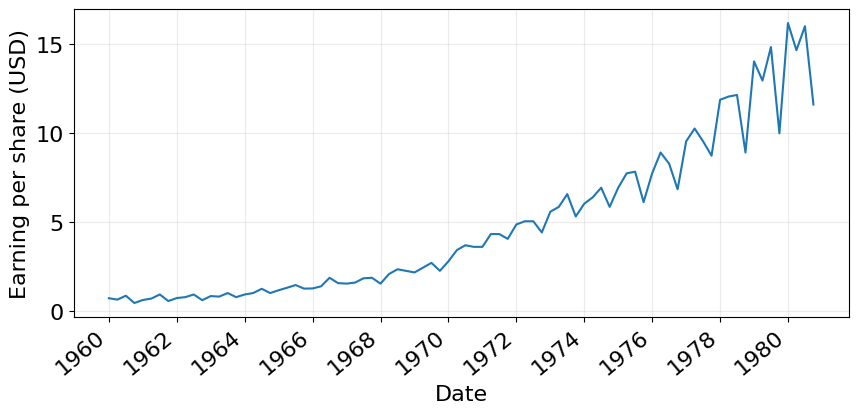

In [5]:
plot_time_series(df_bbca_close["date"], df_bbca_close["data"], 
                 xlabel="Date", ylabel="Earning per share (USD)")

## 7.1 Defining the autoregressive integrated moving average model

**Autoregressive integrated moving average model**   
An _autoregressive integrated moving average_ (ARIMA) process is the combination  
of the $\text{AR}(p)$ and $\text{MA}(q)$ processes, but in terms of the differenced  
series.  

It is denoted as $\text{ARIMA}(p, d, q)$, where $p$ is the order of the $\text{AR}(p)$  
process, $d$ is the order of integration, and $q$ is the order of the $\text{MA}(q)$ process.  

Integration is the reverse of differencing, and the order of integration $d$  
is equal to the number of times the series has been differenced to be rendered  
stationary.  

The general equation of the $\text{ARIMA}(p, d, q)$ process is 
$$
  y'_t = C + \varphi_1 y'_{t-1} + \ldots + \varphi_p y'_{t-p} 
    + \theta_1 \epsilon'_{t-1} + \ldots + \theta_q \epsilon'_{t-q} + \epsilon_t
$$  

Note that $y'_t$ representes the differenced series, and it may have been   
differenced more than once.

## 7.2 Modifying the general modeling procedure to account for non-stationary series

From the general procedure in the previous chapter where we use of $\text{ARMA}(p, q)$,  
to get the model, we add another step to get the integration order $d$.   

Please to remember that $\text{ARMA}(p, q)$ only can be applied to the stationary data,  
but $\text{ARIMA}(p, d, q)$ can be either applied to non-stationary or   
stationary data ($d = 0$)

<img src="./figures/identify-nonstationary-general-procedure-arima.drawio.png" width=600>

## 7.3 Forecasting a non-stationary time series

The first step is to determine the integrated order by using ADF statistic

In [6]:
ADF_result = adfuller(df_bbca_close['data'])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 2.7420165734574784
p-value: 1.0


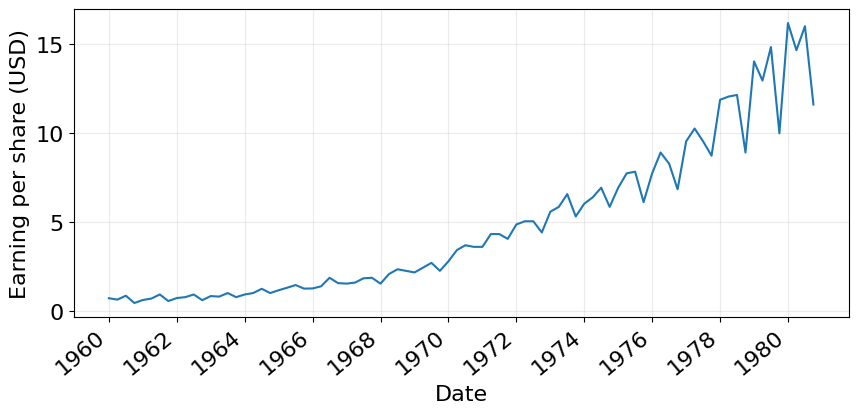

In [7]:
plot_time_series(df_bbca_close["date"], df_bbca_close["data"], 
                 xlabel="Date", ylabel="Earning per share (USD)")

### first-order differencing ($d = 1$)

In [8]:
eps_first_diff = np.diff(df_bbca_close["data"], n=1)
ADF_result = adfuller(eps_first_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.40740976363805026
p-value: 0.9088542416911298


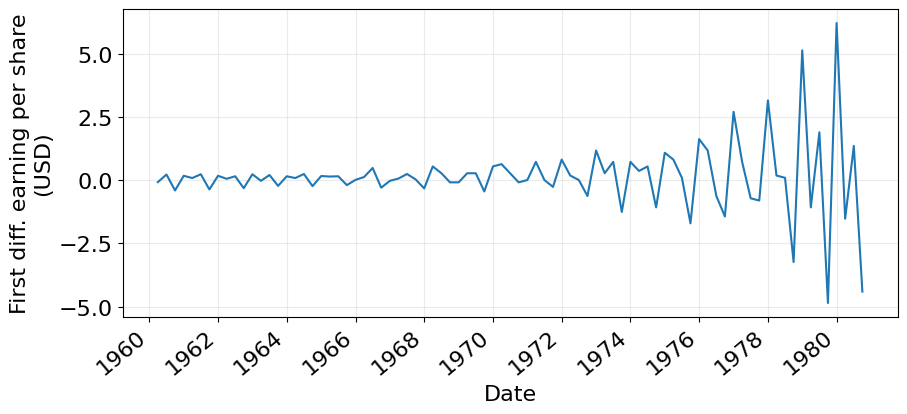

In [9]:
plot_time_series(df_bbca_close["date"].iloc[1:], eps_first_diff, 
                 xlabel="Date", ylabel="First diff. earning per share\n(USD)")

### second-order of difference ($d = 2$)

This differencing does not use `np.diff()` with `n=2`, but we take the first difference
of the first difference.

In [10]:
eps_second_diff = np.diff(eps_first_diff, n=1)
ADF_result = adfuller(eps_second_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -3.585162874793176
p-value: 0.006051099869603258


Because for the second-order difference, we have $p$-value less than 0.05   
of the ADF statistic, we conclude that at least we have to set $d = 2$ in our $\text{ARIMA}(p, d, q)$
model

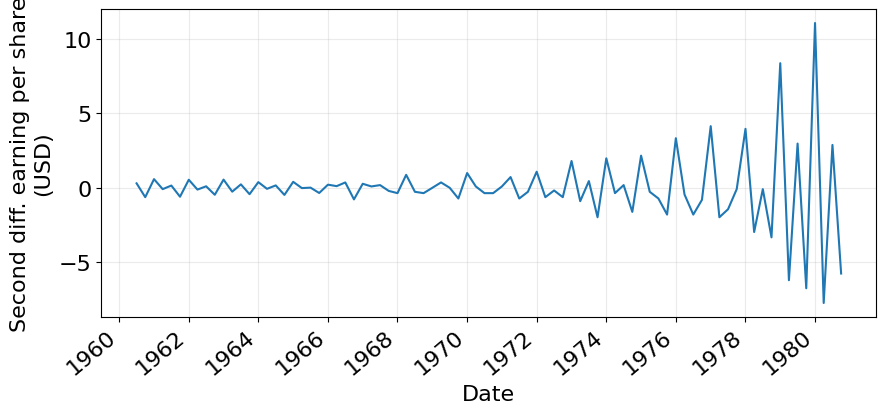

In [11]:
plot_time_series(df_bbca_close["date"].iloc[2:], eps_second_diff, 
                 xlabel="Date", ylabel="Second diff. earning per share\n(USD)")


Split the time series with the last four quarters as the test set.

In [12]:
df_train = df_bbca_close[:-4]    # four quarters of the last year
df_test = df_bbca_close[-4:]

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (80, 4)


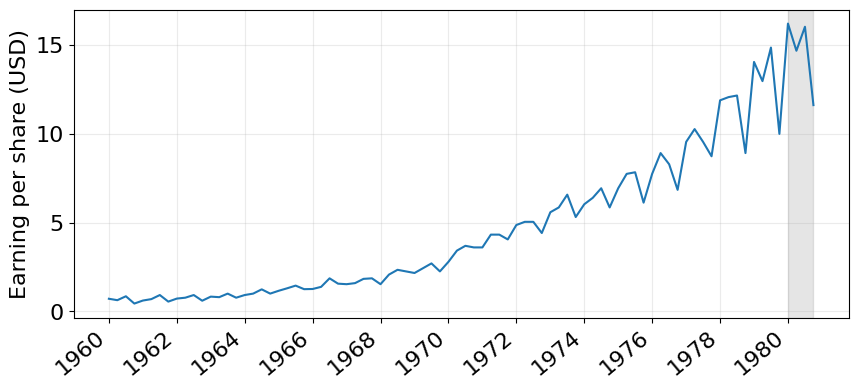

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_bbca_close['date'], df_bbca_close["data"])
ax.grid("on")
ax.set_ylabel("Earning per share (USD)")

formatter = mdates.DateFormatter("%Y")
# formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)


# add forecast area
ax.axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

plt.show(fig)

Using the previous code from chapter 7, we ready to find the best pair
of $(p, q)$ in our model $\text{ARIMA}(p, 2, q)$

In [14]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df


In [15]:
p_space = range(0, 4, 1)
q_space = range(0, 4, 1)
d = 2

print(f"integration order, d = {d}")
order_list = list(itertls.product(p_space, q_space))
order_list


integration order, d = 2


[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3)]

In [16]:
result_df = optimize_ARIMA(df_train["data"], order_list, d,
                           enforce_invertibility=True,
                           enforce_stationarity=True)
result_df

  0%|          | 0/16 [00:00<?, ?it/s]

(0, 0)
(0, 1)
(0, 2)
(0, 3)


c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(1, 0)
(1, 1)
(1, 2)
(1, 3)


c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 0)
(2, 1)
(2, 2)
(2, 3)


c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(3, 0)
(3, 1)
(3, 2)


c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(3, 3)


c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(3, 3)",115.272879
1,"(3, 1)",115.624980
2,"(3, 2)",115.672007
3,"(3, 0)",154.430890
4,"(0, 3)",194.654716
5,"(0, 2)",209.274603
6,"(2, 3)",220.667183
7,"(1, 3)",228.267777
8,"(1, 2)",228.935914
9,"(2, 2)",229.974721


In [28]:
# best_p, best_q = result_df.iloc[np.argmin(result_df["AIC"])]["(p,q)"]
best_p, best_q = (3, 1)
print(f"best (p,q): {(best_p, best_q)}")

best (p,q): (3, 1)


Perform residual analysis

In [29]:
model_arima_best = SARIMAX(df_train["data"], order=(best_p, d, best_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

c:\Users\ASUS\miniconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


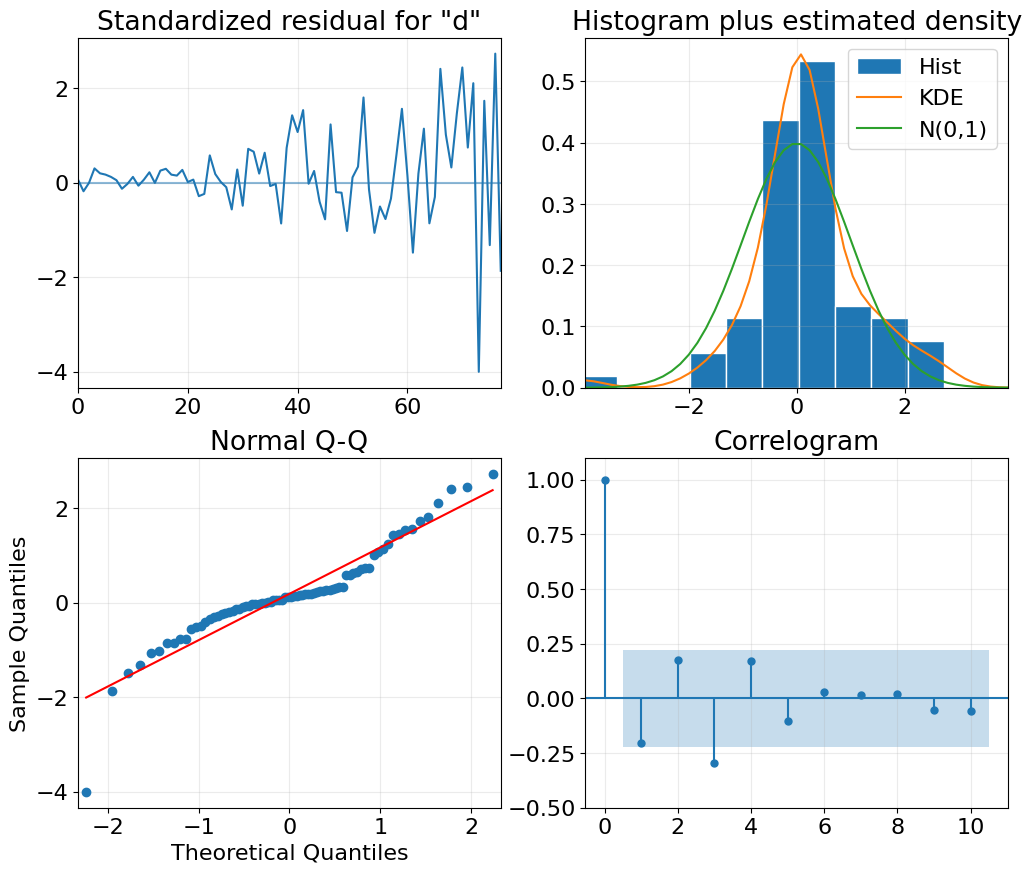

In [30]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

Quantitative test for residual analysis

In [31]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,4.171207,0.041116
2,7.048262,0.029477
3,14.311891,0.002510
4,16.424643,0.002499
5,17.218947,0.004103
6,17.290382,0.008273
7,17.320583,0.015442
8,17.351805,0.026647
9,17.582067,0.040344
10,17.876410,0.057085


All the $p$-values above are greater than 0.05. Therefore we do not reject null  
hypothesis, and we conclude that the residuals are not correlated, just like white noise

Now we can use our $\text{ARIMA}(3, 2, 3)$ model to forecast all quarters
in the last year.  
For the benchmark, we also compare it with the naive model.

In [32]:
df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)   # 4 points

pred_mean = np.ones(HORIZON)*np.mean(df_train["data"])
pred_naive_seasonal = df_train["data"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_mean"] = pred_mean
df_test_pred["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred["pred_arima"] = pred_arima

df_test_pred.head()


,date,data,pred_mean,pred_naive_seasonal,pred_arima
80,1980-01-01,16.20,4.3085,14.04,15.574004
81,1980-04-01,14.67,4.3085,12.96,14.413268
82,1980-07-02,16.02,4.3085,14.85,16.380958
83,1980-10-01,11.61,4.3085,9.99,11.715672


Then we plot all the forecasting results

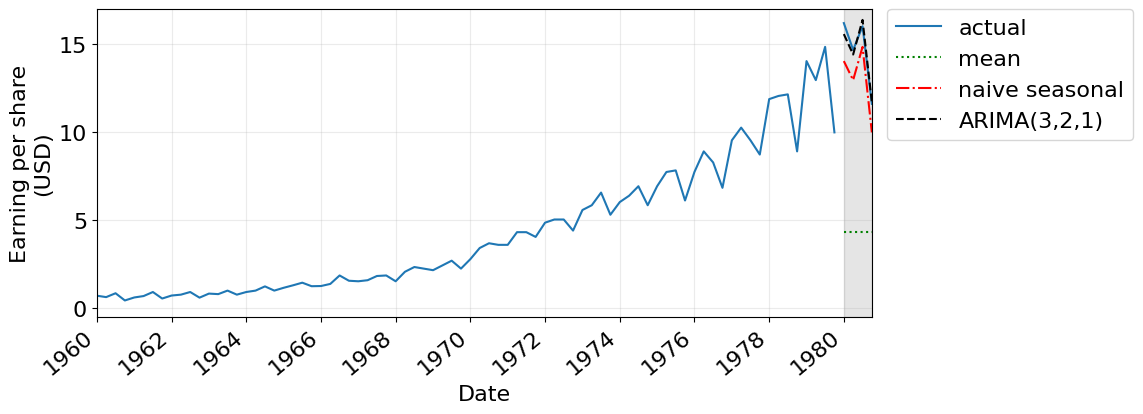

In [39]:
start_idx = 0  # for better visualization
xlim = [df_train["date"].iloc[start_idx], df_test["date"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["date"], df_train["data"])
ax.plot(df_test["date"], df_test["data"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y")
# formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=2)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Earning per share\n(USD)")

# -- prediction
ax.plot(df_test_pred["date"], df_test_pred["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred["date"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["date"], df_test_pred["pred_arima"], "k--", 
        label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

zoom in to the forecast area

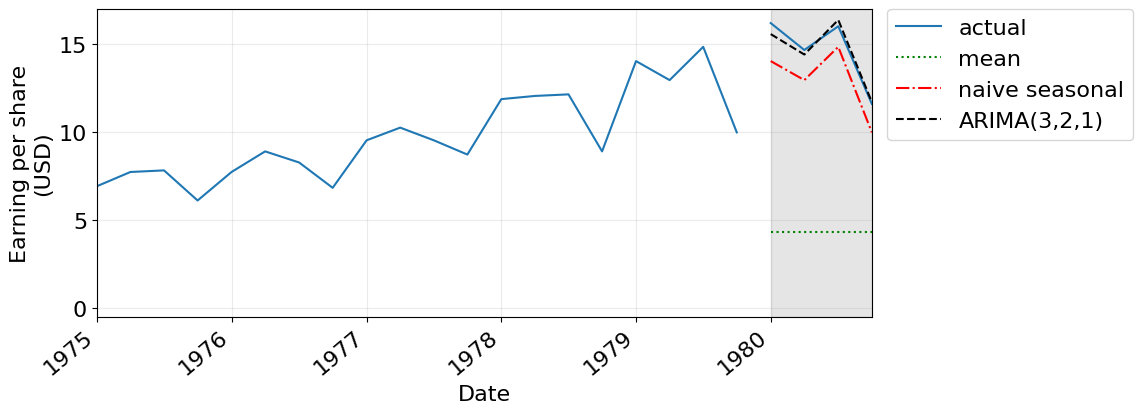

In [40]:
start_idx = 60  # for better visualization
xlim = [df_train["date"].iloc[start_idx], df_test["date"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["date"], df_train["data"])
ax.plot(df_test["date"], df_test["data"], color="tab:blue", label="actual")

formatter = mdates.DateFormatter("%Y")
# formatter = mdates.DateFormatter("%Y-%b-%d")
locator = mdates.YearLocator(base=1)
# locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Earning per share\n(USD)")

# -- prediction
ax.plot(df_test_pred["date"], df_test_pred["pred_mean"], "g:", label="mean")
ax.plot(df_test_pred["date"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["date"], df_test_pred["pred_arima"], "k--", 
          label=f"ARIMA({best_p},{d},{best_q})")

# add forecast area
ax.axvspan(df_test['date'].iloc[0], df_test['date'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

Evaluate the models

In [35]:
mae_mean           = mean_absolute_error(df_test_pred["data"], df_test_pred["pred_mean"])
mae_naive_seasonal = mean_absolute_error(df_test_pred["data"], df_test_pred["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred["data"], df_test_pred["pred_arima"])

print(f"          MAE mean: {mae_mean}")
print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"         MAE ARIMA: {mae_arima}")

          MAE mean: 10.3165000125
MAE naive seasonal: 1.6649999999999996
         MAE ARIMA: 0.33733955326132437


In [36]:
mape_mean           = mean_absolute_percentage_error(df_test_pred["data"], df_test_pred["pred_mean"]) * 100
mape_naive_seasonal = mean_absolute_percentage_error(df_test_pred["data"], df_test_pred["pred_naive_seasonal"]) * 100 
mape_arima          = mean_absolute_percentage_error(df_test_pred["data"], df_test_pred["pred_arima"]) * 100

print(f"          MAPE mean: {mape_mean:5.2f}%")
print(f"MAPE naive seasonal: {mape_naive_seasonal:5.2f}%")
print(f"         MAPE ARIMA: {mape_arima:5.2f}%")

          MAPE mean: 70.01%
MAPE naive seasonal: 11.56%
         MAPE ARIMA:  2.19%


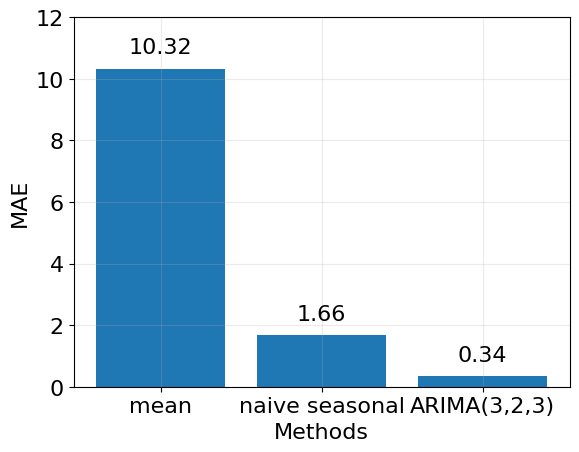

In [37]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(3,2,3)"]
y_array = [mae_mean, mae_naive_seasonal, mae_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 12])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.5, s=f"{val:.2f}", ha="center")

plt.show(fig)


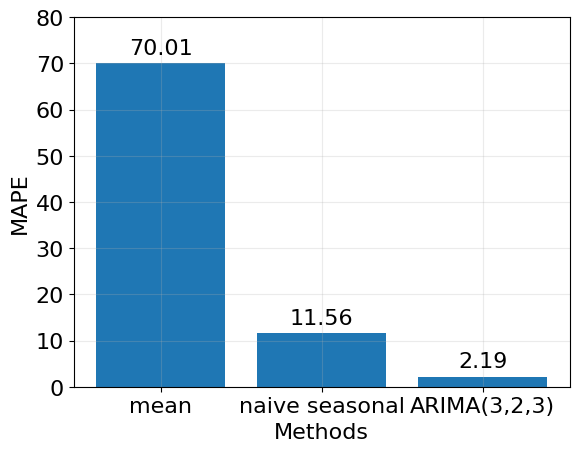

In [38]:
fig, ax = plt.subplots()

x_array = ["mean", "naive seasonal", "ARIMA(3,2,3)"]
y_array = [mape_mean, mape_naive_seasonal, mape_arima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 80])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+2, s=f"{val:.2f}", ha="center")

plt.show(fig)



## 7.4 Next steps

We have studied the Johnson & Johnson dataset enough times to realize that there  
are clear cylical patterns in the time series.   
To integrate the seasonality of a series in a model, we must use the 
_seasonal autoregressive integrated moving average_ (SARIMA) model, or  
$\text{SARIMA}(p,d,q)(P,D,Q)_{m}$